In [11]:
import numpy as np

from elastica.wrappers import BaseSystemCollection, Constraints, Forcing
from elastica.rod.cosserat_rod import CosseratRod
from elastica.boundary_conditions import HelicalBucklingBC
from elastica.timestepper.symplectic_steppers import PositionVerlet, PEFRL
from elastica.timestepper import integrate
# from examples.HelicalBucklingCase.helicalbuckling_postprocessing import (
#     plot_helicalbuckling,
# )

In [12]:

class HelicalBucklingSimulator(BaseSystemCollection, Constraints, Forcing):
    pass

helicalbuckling_sim = HelicalBucklingSimulator()

In [13]:
# setting up test params
n_elem = 300
start = np.zeros((3,))
direction = np.array([0.0, 0.0, 1.0])
normal = np.array([0.0, 1.0, 0.0])
base_length = 100.0
base_radius = 0.35
base_area = np.pi * base_radius ** 2
density = 1.0 / (base_area)
nu = 0.01
E = 1e6
slack = 3
number_of_rotations = 27
# For shear modulus of 1e4, nu is 99!
poisson_ratio = 99
shear_matrix = np.repeat(1e5 * np.identity((3))[:, :, np.newaxis], n_elem, axis=2)
temp_bend_matrix = np.zeros((3, 3))
np.fill_diagonal(temp_bend_matrix, [1.345, 1.345, 0.789])
bend_matrix = np.repeat(temp_bend_matrix[:, :, np.newaxis], n_elem - 1, axis=2)


In [14]:

shearable_rod = CosseratRod.straight_rod(
    n_elem,
    start,
    direction,
    normal,
    base_length,
    base_radius,
    density,
    nu,
    E,
    poisson_ratio,
)

shearable_rod.shear_matrix = shear_matrix
shearable_rod.bend_matrix = bend_matrix

helicalbuckling_sim.append(shearable_rod)


In [15]:

helicalbuckling_sim.constrain(shearable_rod).using(
    HelicalBucklingBC,
    constrained_position_idx=(0, -1),
    constrained_director_idx=(0, -1),
    twisting_time=500,
    slack=slack,
    number_of_rotations=number_of_rotations,
)



In [16]:
helicalbuckling_sim.finalize()


In [17]:
timestepper = PositionVerlet()


In [18]:
shearable_rod.velocity_collection[..., int((n_elem) / 2)] += np.array([0, 1e-6, 0.0])


In [19]:
final_time = 1050.0
dl = base_length / n_elem
dt = 1e-3 * dl
total_steps = int(final_time / dt)
print("Total steps", total_steps)


Total steps 3150000


In [20]:
integrate(timestepper, helicalbuckling_sim, final_time, total_steps)

100%|██████████| 3150000/3150000 [34:03<00:00, 1541.12it/s]

Final time of simulation is :  1050.0000000803852


In [21]:
def envelope(arg_pos):
    from scipy.linalg import norm
    """
    Given points, computes the arc length and envelope of the curve
    """
    n_points = arg_pos.shape[1]

    # Computes the direction in which the rod points
    # in our cases it should be the z-axis
    rod_direction = arg_pos[:, -1] - arg_pos[:, 0]
    rod_direction /= norm(rod_direction, ord=2, axis=0)

    # Compute local tangent directions
    tangent_s = np.diff(arg_pos, n=1, axis=-1)  # x_(i+1)-x(i)
    length_s = norm(tangent_s, ord=2, axis=0)
    tangent_s /= length_s

    # Dot product with direction is cos_phi, see RSOS
    cos_phi_s = np.einsum("ij,i->j", tangent_s, rod_direction)

    # Compute phi-max now
    phi = np.arccos(cos_phi_s)
    cos_phi_max = np.cos(np.max(phi))

    # Return envelope and arclength
    envelope = (cos_phi_s - cos_phi_max) / (1.0 - cos_phi_max)
    # -0.5 * length accounts for the element/node business
    arclength = np.cumsum(length_s) - 0.5 * length_s[0]

    return arclength, envelope


def analytical_solution(L, n_elem=10000):
    """ Gives the analytical solution of the helicalbuckling case
    """
    # Physical parameters, set from the simulation
    B = 1.345
    C = 0.789
    gamma = C / B
    R = 27.0 * 2.0 * np.pi
    d = 0.03
    D = d * L
    nu = 1.0 / gamma - 1.0

    # These are magic constants, but you can obtain them by solving
    # this equation (according to matlab syntax)
    # syms x y
    # S = vpasolve([d == sqrt(16/y*(1-x*x/(4*y))), R == x/gamma+4*acos(x/(2*sqrt(y)))], [x, y]);
    # moment = double(S.x); # dimensionless end moment
    # tension = double(S.y); # dimensionless end torque
    # This comes from  Eqs. 14-15 of "Writhing instabilities of twisted rods: from
    # infinite to finite length", 2001
    # We did not want to introduce sympy dependency here, so we decided to hardcode
    # the solutions instead
    moment = 98.541496171190744
    tension = 2.900993205792131e3

    # Compute maximum envelope angle according to Eq. 13 of "Writhing
    # instabilities of twisted rods: from infinite to finite length", 2001
    thetaMax = np.arccos(moment * moment / (2.0 * tension) - 1.0)

    # Compute actual end torque and tension according to "Writhing
    # instabilities of twisted rods: from infinite to finite length", 2001
    M = moment * B / L
    T = tension * B / (L * L)

    # Compute dimensionless load according to Eq. 30 of "Helical and localised
    # buckling in twisted rods: a unified analysis of the symmetric case", 2000
    m = M / np.sqrt(B * T)

    # Setup for analytical curve calculation
    s = np.linspace(-0.5, 0.5, n_elem)
    t = T * L * L / (4 * np.pi * np.pi * B)
    mz = M * L / (2 * np.pi * B)
    root = np.sqrt(4 * t - mz * mz)

    # This is the analytical curve computed
    # according to Eqs. 27 and 52 of
    # "Instability and self-contact phenomena in the writhing of clamped rods",
    # 2003
    xs = (1.0/ (2.0 * np.pi * t)* root* np.sin(mz * np.pi * s)/ np.cosh(np.pi * s * root))
    ys = (-1.0/ (2.0 * np.pi * t)* root* np.cos(mz * np.pi * s)/ np.cosh(np.pi * s * root))
    zs = s - 1.0 / (2.0 * np.pi * t) * root * np.tanh(np.pi * s * root)
    pos = np.vstack((xs, ys, zs)) * L
    return envelope(pos)


<IPython.core.display.Javascript object>


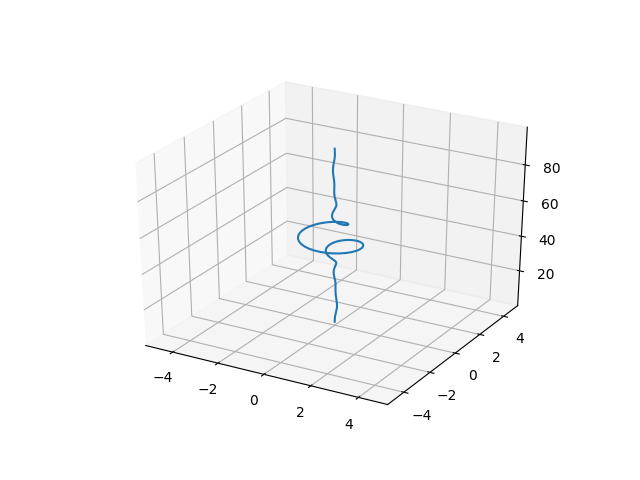

<IPython.core.display.Javascript object>


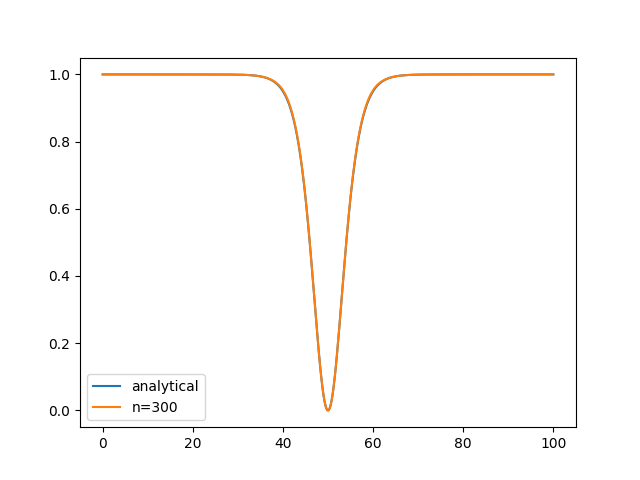

In [22]:
%matplotlib notebook

from matplotlib import pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib.colors import to_rgb

def plot_helicalbuckling(rod, SAVE_FIGURE):

    plt.figure()
    plt.axes(projection="3d")
    plt.plot(rod.position_collection[0, ...],
             rod.position_collection[1, ...],
             rod.position_collection[2, ...]
            )
    plt.xlim([-5, 5])
    plt.ylim([-5, 5])
    if SAVE_FIGURE:
        plt.savefig("HelicalBuckling_3d" + str(rod.n_elems) + ".png")
    plt.show()

    base_length = np.sum(rod.rest_lengths)
    phi_analytical_envelope = analytical_solution(base_length)
    phi_computed_envelope = envelope(rod.position_collection)

    plt.figure()
    plt.plot(phi_analytical_envelope[0], phi_analytical_envelope[1], label="analytical")
    plt.plot(phi_computed_envelope[0],phi_computed_envelope[1],label="n=" + str(rod.n_elems))
    plt.legend()
    if SAVE_FIGURE:
        plt.savefig("HelicalBuckling_Envelope" + str(rod.n_elems) + ".png")
    plt.show()

    
# Options
PLOT_FIGURE = True
SAVE_FIGURE = True



plot_helicalbuckling(shearable_rod, SAVE_FIGURE)

  0%|          | 305/315000 [00:00<03:25, 1532.24it/s]

Total steps 315000


100%|██████████| 315000/315000 [03:27<00:00, 1520.87it/s]

Final time of simulation is :  105.00000000092506


<IPython.core.display.Javascript object>


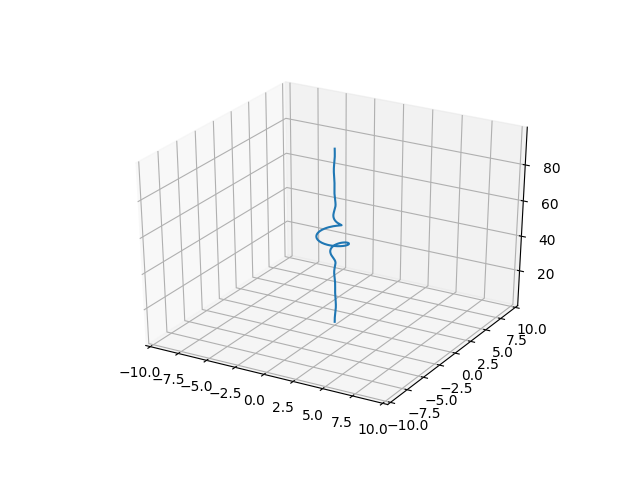

<IPython.core.display.Javascript object>


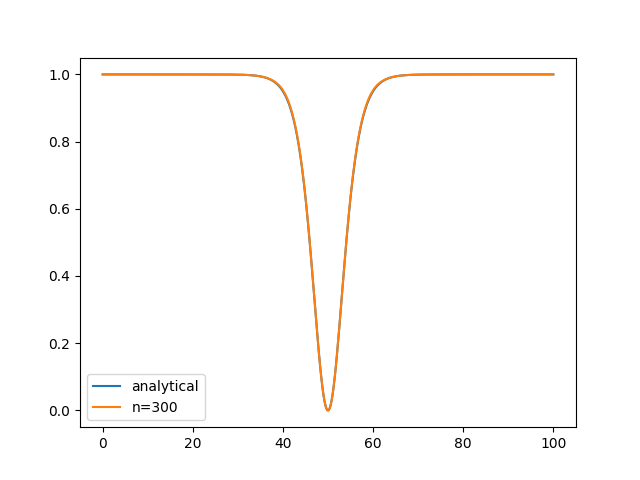

<IPython.core.display.Javascript object>


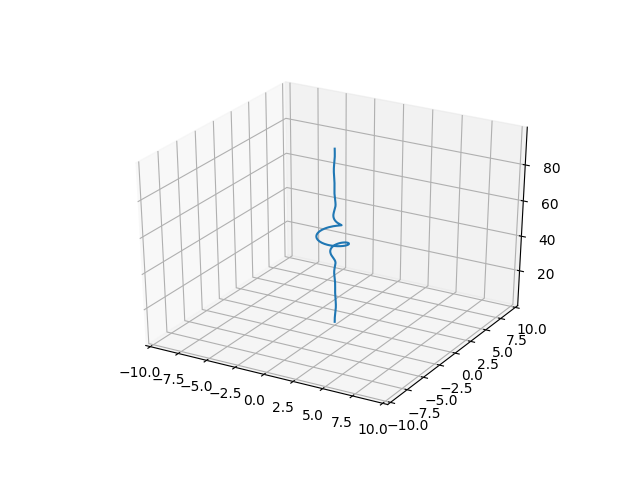

<IPython.core.display.Javascript object>


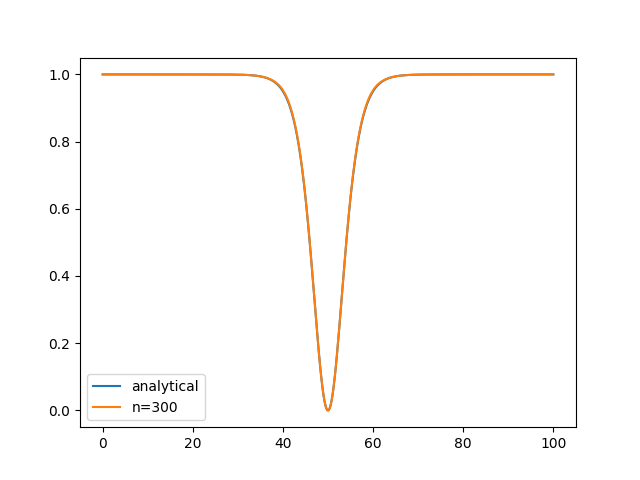

In [7]:
%matplotlib notebook

plot_helicalbuckling(shearable_rod, SAVE_FIGURE)